# Data PreProcessing


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out=pd.read_csv(loc,**kwargs)
    return out

In [3]:
fname=("./uiuc-gpa-dataset.csv","https://drive.google.com/file/d/1NjCKO79SjdTfIxXWjQWAE0OzqAsM-Ysy/view?usp=sharing")
df=getfile(fname)
df.head()

,Year,Term,YearTerm,Subject,Number,Course Title,Sched Type,A+,A,A-,...,B-,C+,C,C-,D+,D,D-,F,W,Primary Instructor
0,2023,Spring,2023-sp,AAS,100,Intro Asian American Studies,DIS,0,11,5,...,0,0,0,0,0,0,0,1,0,"Shin, Jeongsu"
1,2023,Spring,2023-sp,AAS,100,Intro Asian American Studies,DIS,0,17,2,...,1,0,0,0,0,0,0,0,1,"Shin, Jeongsu"
2,2023,Spring,2023-sp,AAS,100,Intro Asian American Studies,DIS,0,13,2,...,2,0,0,1,0,0,0,1,0,"Lee, Sabrina Y"
3,2023,Spring,2023-sp,AAS,200,U.S. Race and Empire,LCD,6,15,5,...,0,0,0,0,0,1,0,1,0,"Sawada, Emilia"
4,2023,Spring,2023-sp,AAS,215,US Citizenship Comparatively,LCD,16,12,2,...,1,0,0,0,0,0,0,0,0,"Kwon, Soo Ah"


In [4]:
parameter_columns = ['Subject', 'Number', 'YearTerm', 'Sched Type', 'Primary Instructor']
temp = df[parameter_columns].values
X = []
for i in range(len(temp)):
    X.append([str(temp[i,0]), str(temp[i,1]), str(temp[i,2]), str(temp[i,3]), str(temp[i,4])])
X = np.array(X)
X[0]

array(['AAS', '100', '2023-sp', 'DIS', 'Shin, Jeongsu'], dtype='<U25')

In [5]:
grade_columns = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F', 'W']
grade_percent = np.linspace(100,0, len(grade_columns))
print(grade_percent)

temp = df[grade_columns].values
Z = []
for i in range(len(temp)):
    score = np.sum(temp[i]*grade_percent)/np.sum(temp[i])
    idx = (np.abs(grade_percent - score)).argmin()
    Z.append(idx)
Z = np.array(Z)
print(Z[0])
# Prepare data
Z_tensor = torch.tensor(Z, dtype=torch.long)

[100.          92.30769231  84.61538462  76.92307692  69.23076923
  61.53846154  53.84615385  46.15384615  38.46153846  30.76923077
  23.07692308  15.38461538   7.69230769   0.        ]
2


In [6]:
# Extract each feature column
subject_column = X[:, 0]  #  'AAS'
number_column = X[:, 1]   # '100'
term_column = X[:, 2]     # '2023-sp'
sched_type_column = X[:, 3]  # 'DIS'
instructor_column = X[:, 4]  # 'Shin, Jeongsu'

# Initialize label encoders for each column
subject_encoder = LabelEncoder()
number_encoder = LabelEncoder()
term_encoder = LabelEncoder()
sched_type_encoder = LabelEncoder()
instructor_encoder = LabelEncoder()

# Fit and transform each column separately
subject_encoded = subject_encoder.fit_transform(subject_column)
number_encoded = number_encoder.fit_transform(number_column)
term_encoded = term_encoder.fit_transform(term_column)
sched_type_encoded = sched_type_encoder.fit_transform(sched_type_column)
instructor_encoded = instructor_encoder.fit_transform(instructor_column)

# Combine all encoded columns into a single feature array
X_encoded = np.column_stack((subject_encoded, number_encoded, term_encoded, sched_type_encoded, instructor_encoded))

# Convert to PyTorch tensor
X_tensor = torch.tensor(X_encoded, dtype=torch.long)

In [7]:
X_train, X_temp, Z_train, Z_temp = train_test_split(X_tensor, Z_tensor, test_size=0.3, random_state=42)
X_val, X_test, Z_val, Z_test = train_test_split(X_temp, Z_temp, test_size=0.5, random_state=42)

batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, Z_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, Z_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, Z_test), batch_size=batch_size)

# Loading the model

In [8]:
class GradePredictionModel(nn.Module):
    def __init__(self, num_classes, vocab_sizes, dropval=0.3, embedding_dim=50, hidden_dim=128):
        super(GradePredictionModel, self).__init__()

        # Create an embedding for each categorical feature
        self.embeddings = nn.ModuleList(
            [nn.Embedding(vocab_size, embedding_dim) for vocab_size in vocab_sizes]
        )

        # Adjust the input size for the fully connected layers
        self.fc1 = nn.Linear(embedding_dim * len(vocab_sizes), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropval)

    def forward(self, x):
        # Pass each feature through its respective embedding layer
        embedded = [embedding(x[:, i]) for i, embedding in enumerate(self.embeddings)]
        x = torch.cat(embedded, dim=1)  # Concatenate all embeddings

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [11]:
import requests
import io

# Load the entire model
model_data = "./grade_prediction_model.pth"

num_classes = len(grade_percent)
vocab_sizes = [
    len(subject_encoder.classes_),
    len(number_encoder.classes_),
    len(term_encoder.classes_),
    len(sched_type_encoder.classes_),
    len(instructor_encoder.classes_)
]



# Load the model
model = GradePredictionModel(num_classes, vocab_sizes)
model.load_state_dict(torch.load(model_data).state_dict())
# model = torch.load(model_data)
print("Model loaded successfully")



Model loaded successfully


In [12]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    relaxed_score = 0

    with torch.no_grad():
        for X_batch, Z_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)

            total += Z_batch.size(0)
            correct += (predicted == Z_batch).sum().item()

            grade_diff = torch.abs(predicted - Z_batch)
            max_distance = len(grade_columns) - 1
            relaxed_score += (1 - (grade_diff / max_distance)).sum().item()

    relaxed_accuracy = 100 * relaxed_score / total
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Relaxed Test Accuracy: {relaxed_accuracy:.2f}%")
    return accuracy, relaxed_accuracy

evaluate(model, test_loader)

Test Accuracy: 49.79%
Relaxed Test Accuracy: 95.46%


(49.79249107229032, 95.46078325825162)

# Evaluate Feature Importance

In [15]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 12.3 MB/s eta 0:00:0000:01


In [16]:
import shap

In [17]:
def f(X):
    with torch.no_grad():
        # Convert X to LongTensor
        X = torch.LongTensor(X)
        return model(X).numpy()
# Create a background dataset for SHAP
X_train_np = X_train.cpu().numpy()
background = shap.sample(X_train_np, 100)

# Create a SHAP explainer
explainer = shap.KernelExplainer(f, background)

# Calculate SHAP values for the test set

X_test_np = X_test.cpu().numpy()
shap_values = explainer.shap_values(X_test_np[:100])


  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
label_select = 5

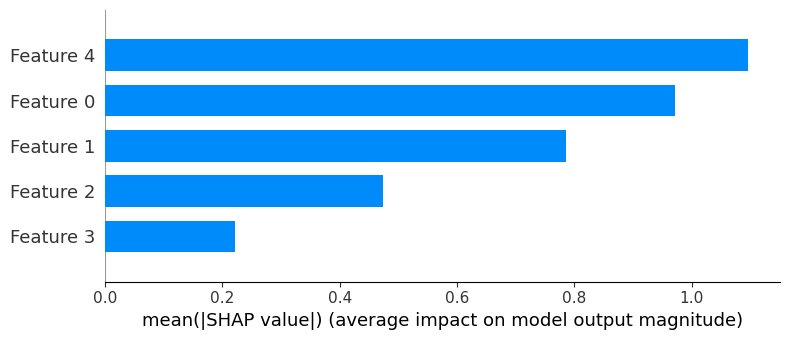

In [19]:
shap.summary_plot(shap_values[:, :, label_select], X_test[:100], plot_type="bar")

Label: A+


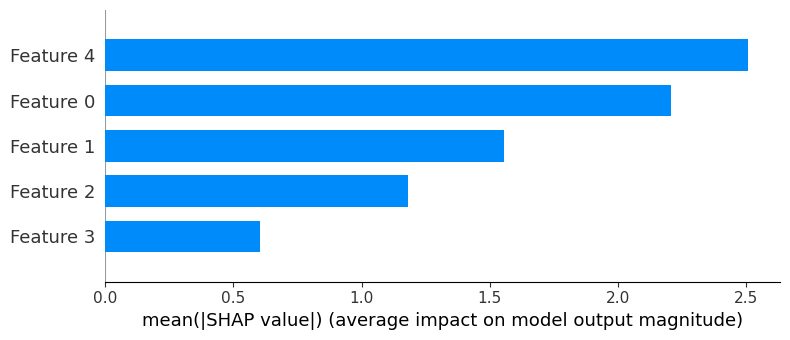

Label: A


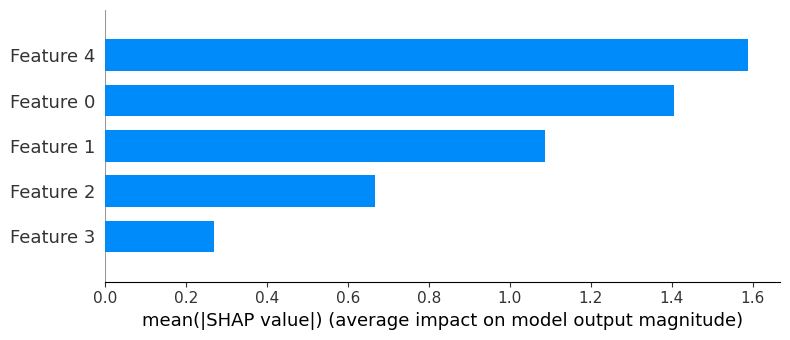

Label: A-


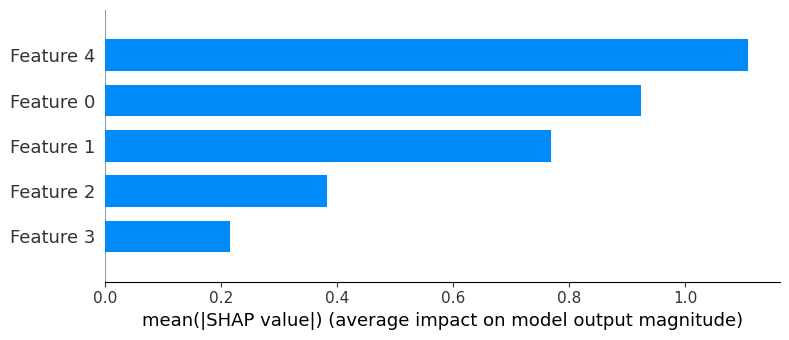

Label: B+


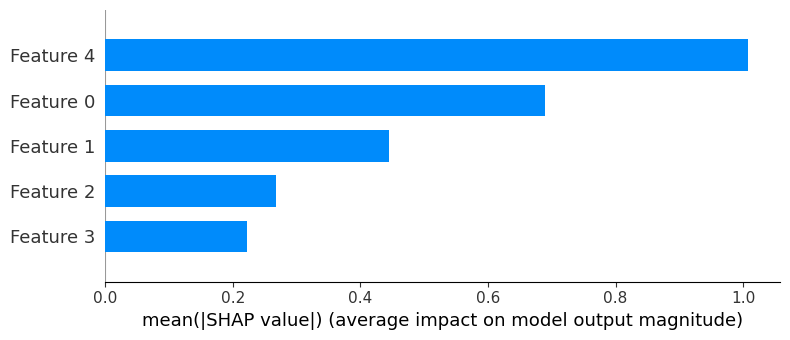

Label: B


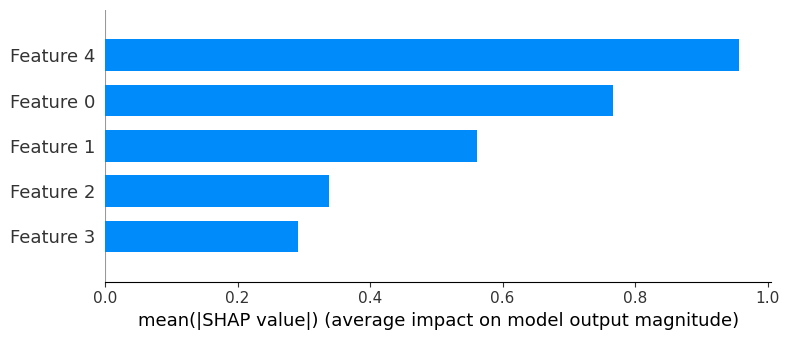

Label: B-


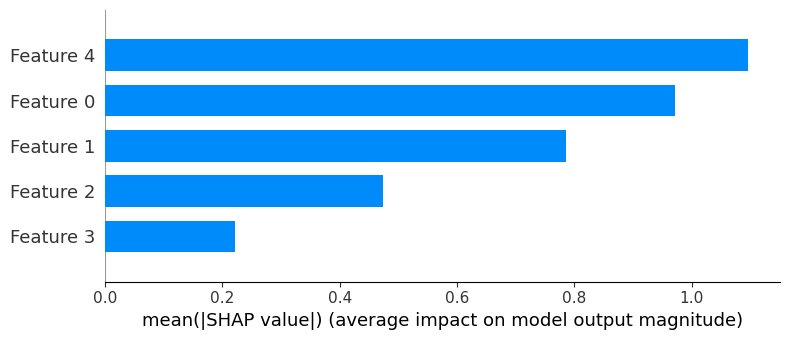

Label: C+


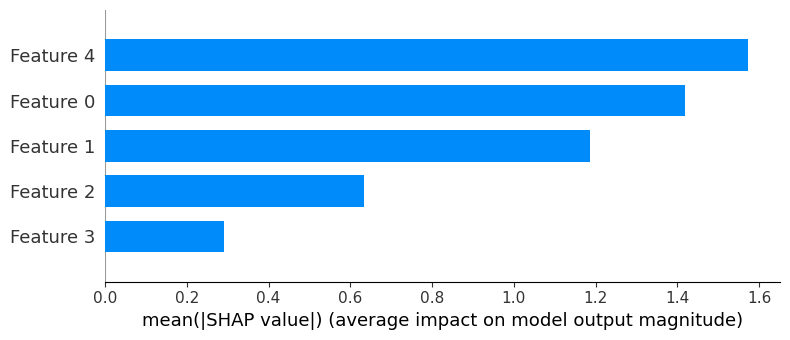

Label: C


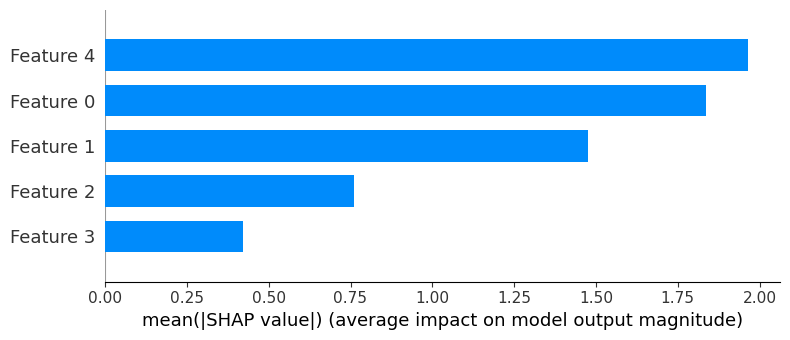

Label: C-


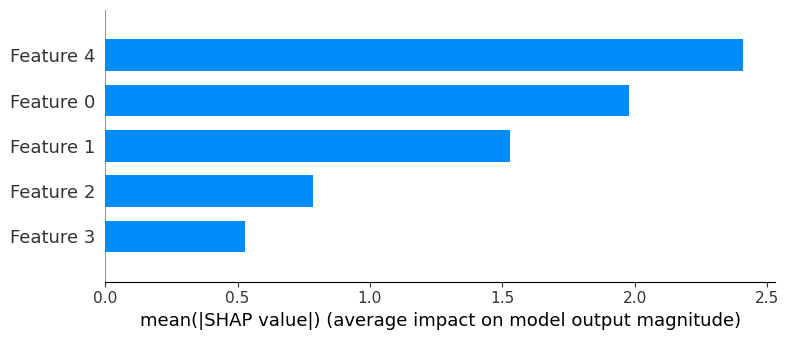

Label: D+


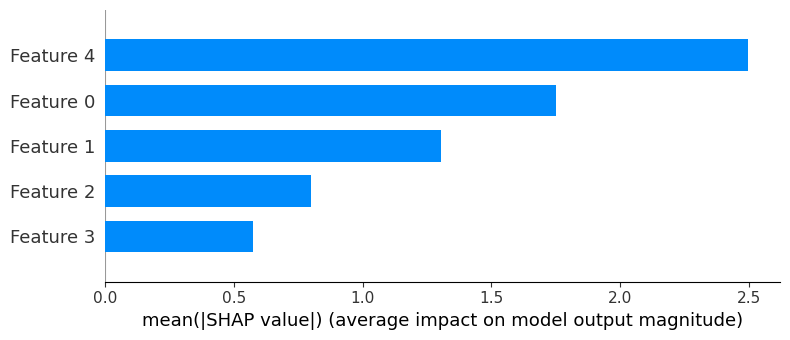

Label: D


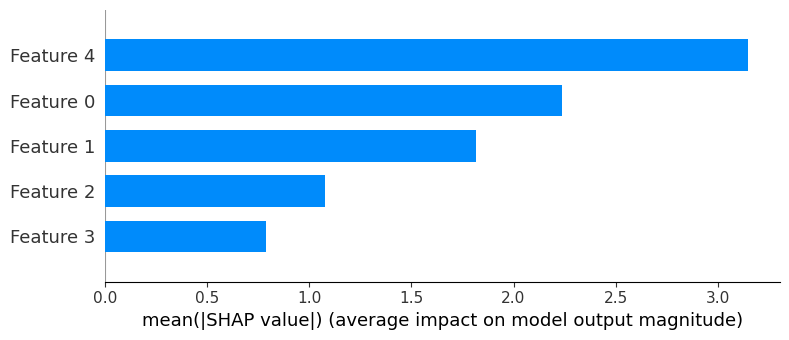

Label: D-


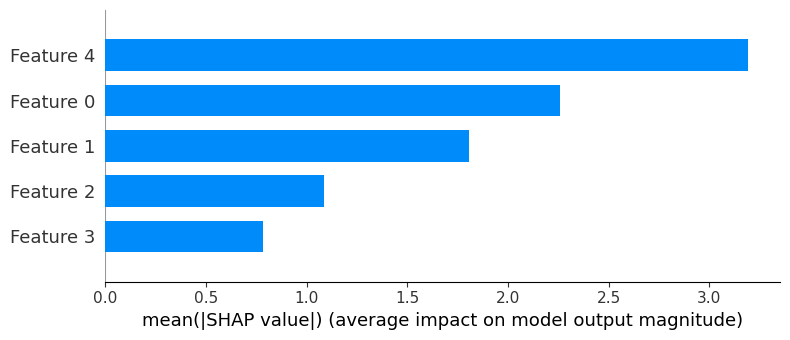

Label: F


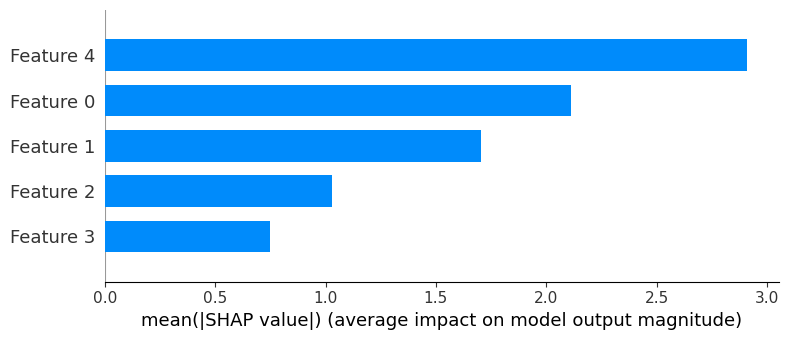

Label: W


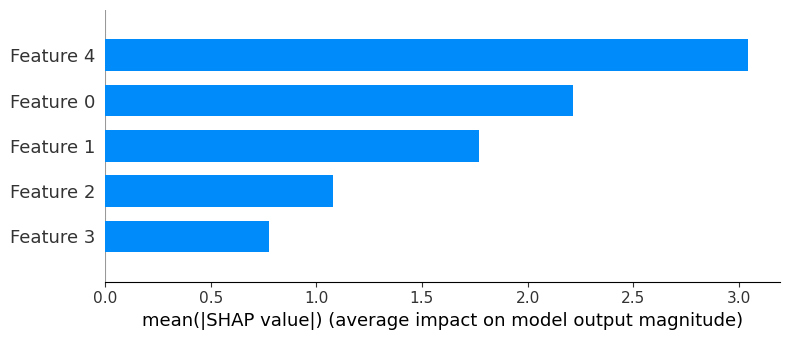

In [20]:
for label in range(14):
    print(f"Label: {grade_columns[label]}")
    shap.summary_plot(shap_values[:, :, label], X_test[:100], plot_type="bar")

[0.25078587 0.17395487 0.07241789 0.10876151 0.41697208]


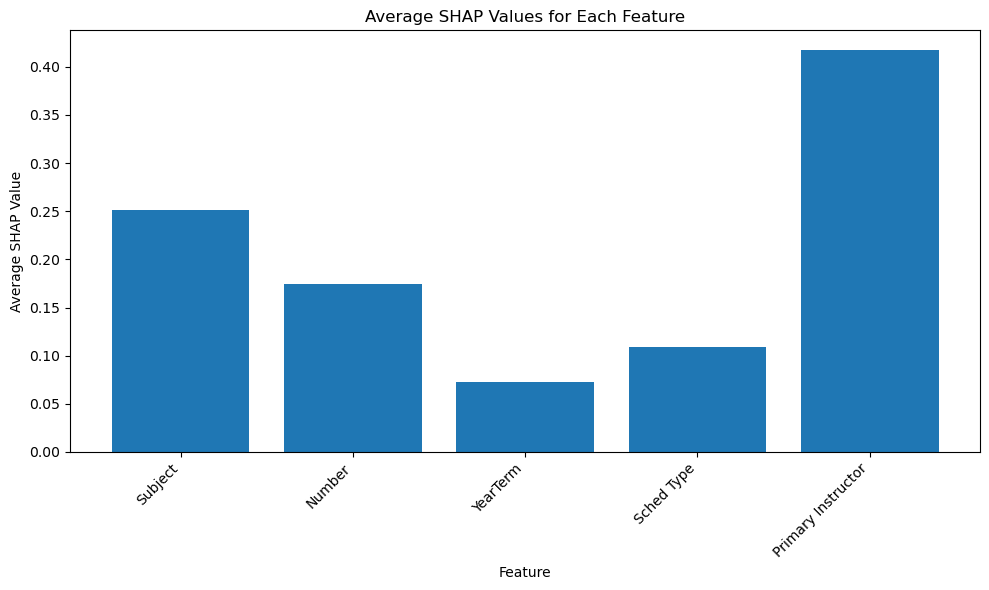

In [21]:
averaged_shap_values = np.mean(shap_values, axis=0)
averaged_shap_values = np.mean(averaged_shap_values, axis=1)

print(averaged_shap_values)


# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(parameter_columns, averaged_shap_values)
plt.xlabel("Feature")
plt.ylabel("Average SHAP Value")
plt.title("Average SHAP Values for Each Feature")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


## **Conclusions**

The feature importance analysis provided valuable insights into the factors that influence grade prediction. Among the encoded features (subject, course number, term, schedule type, and instructor) it was evident that certain features had a higher impact on the performance of the model. For instance:

- **Instructor:** This feature consistently demonstrated a high contribution, suggesting that variations in teaching style or course format could substantially affect student performance.
- **Subject and Course Number:** These features showed a moderate level of importance, reflecting the influence of course content and difficulty level on grades.
- **Term and Schedule Type:** These features appeared less influential, indicating that semesterly variations or yearly differences have a minimal impact on grade distribution within the dataset.

Some minutia that was interesting is at the A+ and A level, the subject was the primary factor versus in all other cases it was clear that the instructor was the primary factor in deciding grade. The implications of this mean that easier subjects have high correlation when looking at the A and A+ range.

The SHAP summary plot provided a clear visualization of the relative contributions. This understanding could guide future iterations of our model, such as emphasizing instructor-level data collection or course-specific interventions, to improve both predictive accuracy and actionable insights.

Moreover, the high relaxed accuracy (\~95%) compared to the standard accuracy (~50%) highlights that while exact grade predictions are challenging, the model effectively captures broader performance trends, emphasizing its utility in educational analysis and decision-making.